In [195]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import pandas_profiling as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [196]:
data=pd.read_csv('winequality-red.csv')

In [197]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## EDA

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [199]:
#RP = ProfileReport(data)
#RP.to_file(output_file='output.html')

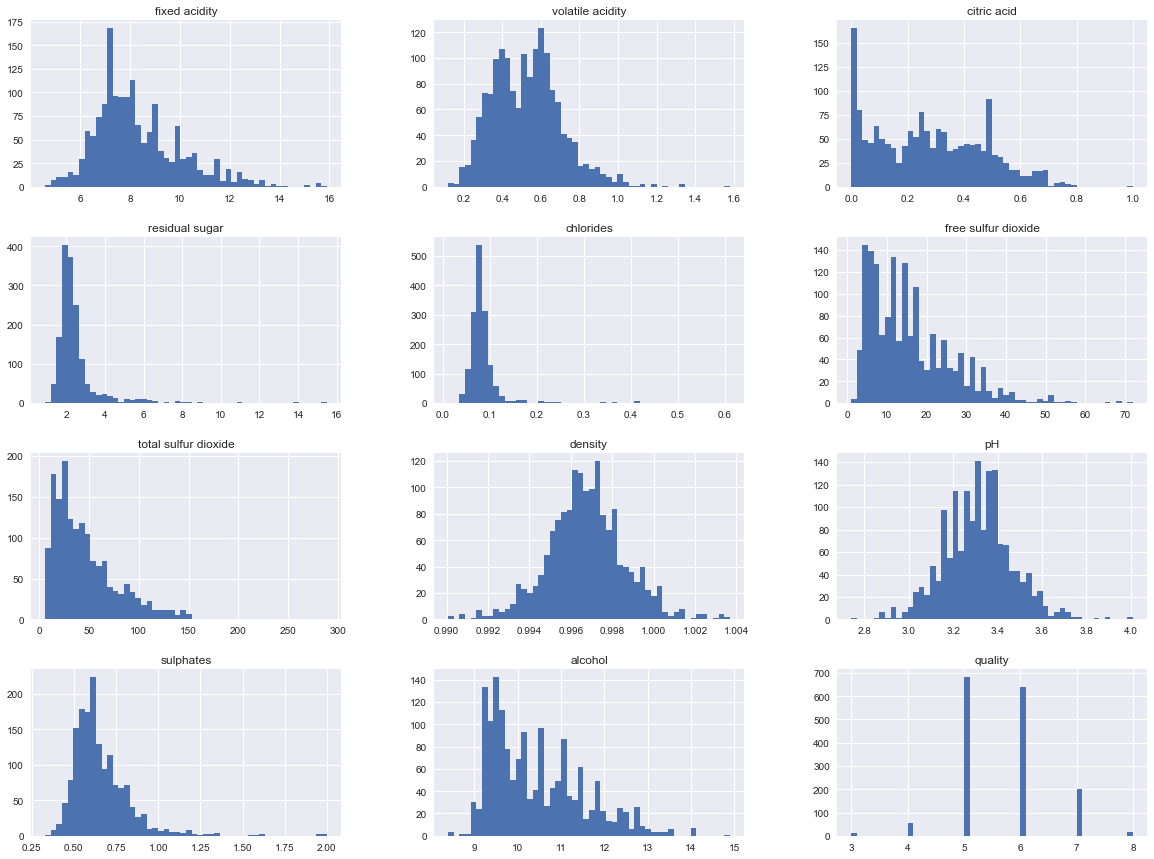

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [201]:
corr_matrix=data.corr()

corr_matrix['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

<AxesSubplot:>

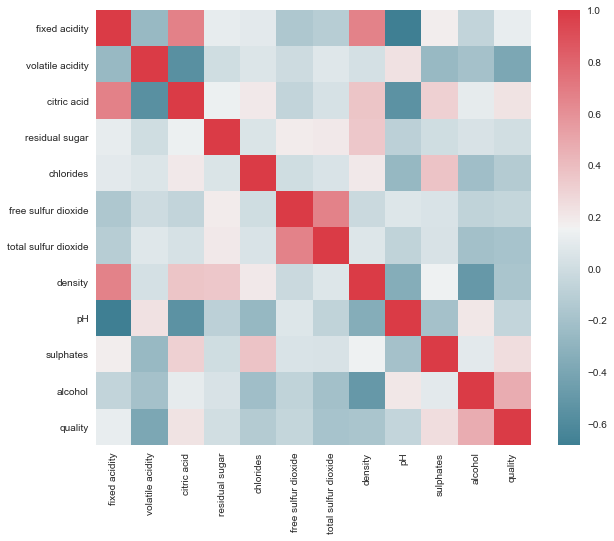

In [202]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

fixed acidity have linear relation ship with density, pH and citric acid

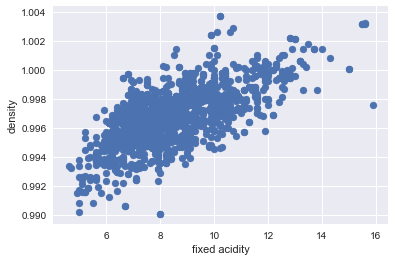

In [203]:
plt.scatter(data['fixed acidity'], data['density'])
plt.xlabel("fixed acidity")
plt.ylabel("density")
plt.show()

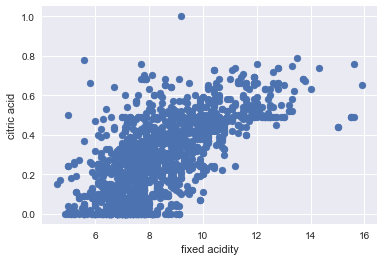

In [204]:
plt.scatter(data['fixed acidity'], data['citric acid'])
plt.xlabel("fixed acidity")
plt.ylabel("citric acid")
plt.show()

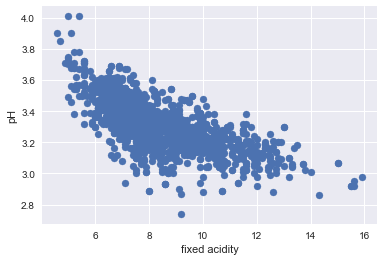

In [205]:
plt.scatter(data['fixed acidity'], data['pH'])
plt.xlabel("fixed acidity")
plt.ylabel("pH")
plt.show()

In [206]:
#X= data.iloc[ : , :-1]


In [207]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [208]:
calc_vif(X)

,variables,VIF
0,fixed acidity,51.643230
1,volatile acidity,16.823738
2,citric acid,9.172773
3,residual sugar,4.662973
4,chlorides,6.234407
5,free sulfur dioxide,6.363828
6,total sulfur dioxide,6.295132
7,density,218.274978
8,sulphates,21.588890
9,alcohol,119.969257


 pH  is correlated with acidity, lower ph value mean more acidic property, we can look at vif of varible 
 it also confirm pH can be explained by other variable present so i am going to drop ph

In [209]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [210]:
X=data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
        'sulphates', 'alcohol']]

In [211]:
# converting the response variables(3-7) as binary response variables that is either good or bad
bins = (2,6.5,8)
labels = ['bad','good']
data['quality'] = pd.cut(data['quality'],bins=bins,labels=labels)

#encoding categorical
le = LabelEncoder()
data['quality'] = le.fit_transform(data['quality'])

#set dependent variable
y=data[['quality']]

In [212]:
data['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# determining the shapes of training and testing sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1071, 10)
(1071, 1)
(528, 10)
(528, 1)


In [214]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

## Logistic Regression

In [215]:
# creating the model
model = LogisticRegression()

# feeding the training set into the model
model.fit(X_train, y_train)

# predicting the results for the test set
y_pred = model.predict(X_test)

# calculating the training and testing accuracies
print("Training accuracy :", model.score(X_train, y_train))
print("Testing accuracy :", model.score(X_test, y_test))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
print(confusion_matrix(y_test, y_pred))

Training accuracy : 0.8879551820728291
Testing accuracy : 0.8693181818181818
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       451
           1       0.61      0.30      0.40        77

    accuracy                           0.87       528
   macro avg       0.75      0.63      0.66       528
weighted avg       0.85      0.87      0.85       528

[[436  15]
 [ 54  23]]


C:\Anaconda3\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [216]:
#roc_auc  score for logistic model

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
auc_score1 = roc_auc_score(y_test, y_pred)

# # k-nearest neighbour

In [229]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# calculating the training and testing accuracies
print("Training accuracy :", model.score(X_train, y_train))
print("Testing accuracy :", model.score(X_test, y_test))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
print(confusion_matrix(y_test, y_pred))

<ipython-input-229-f588bfe80b67>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train,y_train)


Training accuracy : 0.9365079365079365
Testing accuracy : 0.8901515151515151
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       451
           1       0.65      0.53      0.59        77

    accuracy                           0.89       528
   macro avg       0.79      0.74      0.76       528
weighted avg       0.88      0.89      0.89       528

[[429  22]
 [ 36  41]]


In [230]:
#roc_auc  score for KNN model

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred)
auc_score2 = roc_auc_score(y_test, y_pred)


In [231]:
#comparing roc_auc_socre for bothe the model
print(auc_score1, auc_score2)



0.6327209375989864 0.7418435223313271


## Result

logistic regression work slightly better thn KNN 